### calculate CRE activity

In [45]:
import os, sys, re

# plotting functions
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle

# data handling
import scipy
from scipy import stats
from scipy.cluster import hierarchy
import numpy as np
import pandas as pd

from scikit_posthocs import posthoc_tukey
from statannotations.Annotator import Annotator

In [4]:
# set up directories
scriptdir=os.path.join(os.getcwd(), "utils")
sys.path.insert(0, scriptdir)

outbase_dir = os.path.split(os.getcwd())[0]

In [5]:
from utils import sequence_annotator, specseq_ewm_utils, specseq_plot_utils, mpra_CRE_utils, mpra_plot_utils, mpra_qc_normalization, chipseq_plot_utils, chip_rna_annotator
specseq_plot_utils.set_manuscript_params()

### I. read in count matrices 

In [33]:
# annotation table
annot_df = pd.read_csv(os.path.join(outbase_dir, "compiled_counts", "hdmuts_full_annot.tsv"), sep="\t", header=0)
# simple annotation
simple_annot = annot_df.drop_duplicates(subset="annots", keep="first").reset_index(drop=True).set_index("annots")

# plasmid count matrix
plasmid_filtered = pd.read_csv(os.path.join(outbase_dir, "compiled_counts", "030523_plasmid_filteredBCcounts.tsv"), sep="\t", header=0).set_index("barcode")

# DESeq2 normalized rna count matrix
deseq2_normalized_cpm = pd.read_csv(os.path.join(outbase_dir, "DESeq2", "030523_rna_scaled_counts.tsv"), sep="\t", header=0)
deseq2_normalized_cpm.index.name="annots"

### II. calculation of CRE activity - normalize rna counts to plasmid counts

In [21]:
# cpm normalization first for all samples so that they are on the same scale
plasmid_filtered_cpm = plasmid_filtered.apply(lambda count: (count)/plasmid_filtered.sum()*10e6, axis=1)
plasmid_filtered_cpm.head()

,plasmid.libE,plasmid.libF
barcode,,
TTGATCCTAC,514.323273,607.789740
GTCACAACAA,613.675130,735.828901
TAACAGGTGG,71.320440,49.489689
GAGCGCGATG,373.988776,342.377066
GTTGAGGCCA,542.532104,568.162765


In [27]:
# average cpm for plasmid
plasmid_avg = plasmid_filtered_cpm.mean(axis=1).to_frame("plasmid.avg")
plasmid_avg = plasmid_avg.merge(annot_df, on="barcode")

In [31]:
plasmid_avg.to_csv(os.path.join(outbase_dir, "compiled_counts", "normalized", "030523_plasmid_avg.withAnnots.tsv"), sep="\t", index=True, header=True)

In [35]:
# change all the basal annots to a simple "annots" for average
plasmid_avg.loc[plasmid_avg.annots.str.contains("basal"),"annots"]="basal"
plasmid_CRE_avg = plasmid_avg.groupby("annots")["plasmid.avg"].mean().to_frame().merge(simple_annot, left_index=True, right_index=True, how="inner")

# calculate basal mean for plasmid samples
plasmid_basal_avg = plasmid_avg.loc[lambda df: df.label.str.contains("basal"),lambda df: df.columns.str.contains("plasmid")].apply(lambda col: col.mean(), axis=0).mean()

In [39]:
# normalize rna counts to plasmid mean
plasmid_CRE_avg_ser = plasmid_CRE_avg["plasmid.avg"]
# attach the basal average
plasmid_CRE_avg_ser.loc["basal"] = plasmid_basal_avg
deseq2_normalized_ratio = deseq2_normalized_cpm.apply(lambda col: col/plasmid_CRE_avg_ser, axis=0)

In [42]:
deseq2_normalized_ratio.to_csv(os.path.join(outbase_dir, "compiled_counts", "normalized", "030523_rna_deseq2Normed_ratio.tsv"), sep="\t", header=True, index=True)

#### compare basal activity across genotypes

In [47]:
# basal activity means for rna samples
deseq2_basal = deseq2_normalized_cpm.loc[["basal"],:].T
deseq2_basal["genotype"] = deseq2_basal.index.to_frame().applymap(lambda x: x[:-1])
# normalized to plasmid average
deseq2_basal["ratio"] = deseq2_basal["basal"]/plasmid_basal_avg

F_onewayResult(statistic=3.2955320715688767, pvalue=0.031001610583859144)


,index,variable,value
6,wt,ehet,0.884742
12,wt,ehom,0.720125
13,ehet,ehom,0.900000
18,wt,khet,0.633904
19,ehet,khet,0.187546
20,ehom,khet,0.090049
24,wt,khom,0.900000
25,ehet,khom,0.838466
26,ehom,khom,0.670143
27,khet,khom,0.683885


/home/qiaoerrrrr/miniconda3/envs/mpra/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/home/qiaoerrrrr/miniconda3/envs/mpra/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

wt vs. ehet: Custom statistical test, P_val:8.847e-01
wt vs. ehom: Custom statistical test, P_val:7.201e-01
wt vs. khet: Custom statistical test, P_val:6.339e-01
wt vs. khom: Custom statistical test, P_val:9.000e-01
wt vs. rhom: Custom statistical test, P_val:3.167e-01


(<AxesSubplot: title={'center': 'basal activity comparison'}, xlabel='genotype', ylabel='Normalized Activity\n(rna/plasmid)'>,
  <statannotations.Annotation.Annotation at 0x7f201cd712e0>])

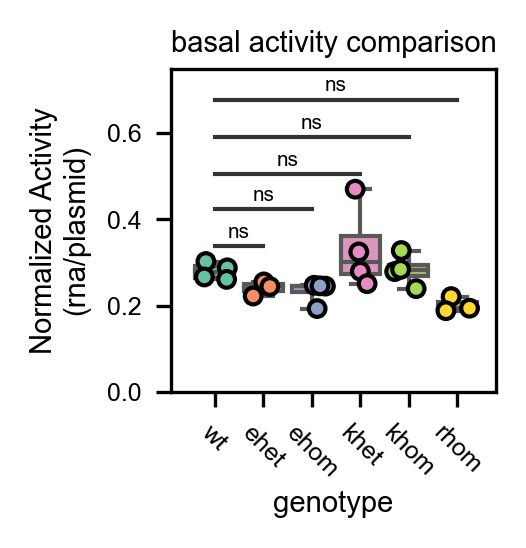

In [49]:
fig, ax = plt.subplots(figsize=(1.4,1.4), dpi=300)

ax = sns.stripplot(y="ratio", x="genotype", data=deseq2_basal, palette="Set2", edgecolor="black", dodge=False, linewidth=1, marker="o", size=4, jitter=.3, orient='v', ax=ax)
ax = sns.boxplot(y="ratio", x="genotype", data=deseq2_basal, 
                                            showmeans=False,
                                            meanprops={"marker":"o",
                                                    "markerfacecolor":"white", 
                                                    "markeredgecolor":"black",
                                                    "markersize":"3"},
                                            whis=np.inf, palette="Set2", orient='v', ax=ax)

#ax.axhline(y=.5, xmin=-.9, xmax=3.8, linewidth=1, linestyle="-.", color="grey")
#ax.axhline(y=1.5, xmin=-.9, xmax=3.8, linewidth=1, linestyle="-.", color="grey")

# compute statistics and add annotation to plot
# do one-way ANOVA with Tukey HSD and store p-values for manual annotation
# transform data to array-like data
gb = deseq2_basal.groupby("genotype")
data_to_anova = [deseq2_basal.groupby("genotype").get_group(x).ratio.to_list() for x in deseq2_basal.groupby("genotype").groups]
# print one-way ANOVA F statistics
print(stats.f_oneway(*data_to_anova))
# Turkey test
tukey_df = posthoc_tukey(deseq2_basal, val_col="ratio", group_col="genotype")
# tidy up Turkey test results
remove = np.tril(np.ones(tukey_df.shape), k=0).astype("bool")
tukey_df[remove] = np.nan
molten_df = tukey_df.melt(ignore_index=False).reset_index().dropna()
molten_df
# print Turkey test result table
display(molten_df)
# retrieve p-values between mutant-wt comparison for plotting
pairs = [(i[1]["index"], i[1]["variable"]) for i in molten_df.iterrows() if i[1]["index"]=="wt"]
p_values = [i[1]["value"] for i in molten_df.iterrows() if i[1]["index"]=="wt"]

# decorations
ax.set_ylim(0,0.6)
ax.set_yticks([0,.2,.4,.6])
ax.set_xlim(-.9,5.8)
ax.set(xlabel="genotype", title="basal activity comparison")
ax.set_ylabel("Normalized Activity\n(rna/plasmid)", labelpad=4)
ax.set_xticklabels(ax.get_xticklabels(), rotation = -45)

# only plot p-values compared to WT
annotator = Annotator(
    ax, pairs, y="ratio", x="genotype", data=deseq2_basal, orient='v', order=["wt","ehet","ehom","khet","khom","rhom"]
)
annotator.configure(text_format='star', loc='inside', line_width=mpl.rcParams["lines.linewidth"], line_height=0.0)
annotator.set_pvalues_and_annotate(p_values)

In [50]:
# use DESeq2 normalized counts for between sample comparison
deseq2_scrambled = pd.DataFrame(index=deseq2_normalized_ratio.index[deseq2_normalized_ratio.index.str.contains("scrambled")])
for genotype in ["wt","ehet","ehom","khet","khom","rhom"]:
    deseq2_scrambled[f"{genotype}.ratio"] = deseq2_normalized_ratio.loc[:,lambda df: df.columns[df.columns.str.contains(genotype)]].apply(lambda x: x.mean(), axis=1)
    # transform the dataframe so that CREs are in columns
deseq2_scrambled = deseq2_scrambled.loc[:,pd.Series(["wt","ehet","ehom","khet","khom","rhom"])+".ratio"].T
deseq2_scrambled["genotype"] = deseq2_scrambled.index.to_frame().applymap(lambda x: x[:-6])
# convert to long form dataframe
deseq2_scrambled_melted = pd.melt(deseq2_scrambled, id_vars=["genotype"], value_vars=deseq2_scrambled.columns[:-1], var_name="CRE", value_name="ratio")

F_onewayResult(statistic=nan, pvalue=nan)


,index,variable,value
6,wt,ehet,0.900000
12,wt,ehom,0.900000
13,ehet,ehom,0.900000
18,wt,khet,0.507728
19,ehet,khet,0.599081
20,ehom,khet,0.283723
24,wt,khom,0.810718
25,ehet,khom,0.719363
26,ehom,khom,0.900000
27,khet,khom,0.039081


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

wt vs. ehet: Custom statistical test, P_val:9.000e-01
wt vs. ehom: Custom statistical test, P_val:9.000e-01
wt vs. khet: Custom statistical test, P_val:5.077e-01
wt vs. khom: Custom statistical test, P_val:8.107e-01
wt vs. rhom: Custom statistical test, P_val:3.407e-01


(<AxesSubplot: title={'center': 'scrambled CRE activity comparison'}, xlabel='genotype', ylabel='Normalized Activity\n(rna/plasmid)'>,
  <statannotations.Annotation.Annotation at 0x7f201cd54730>])

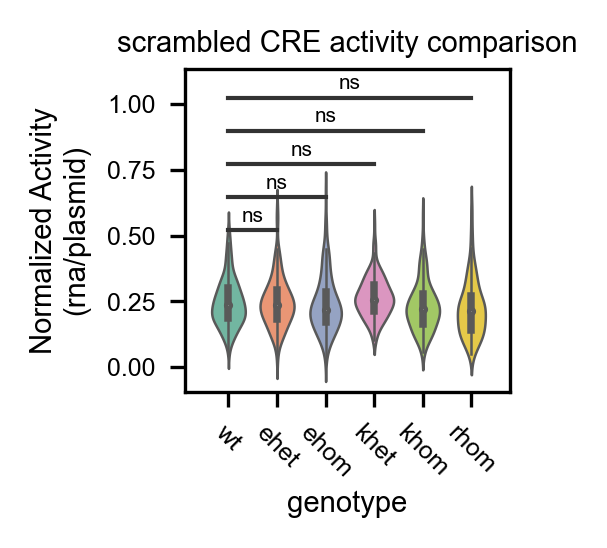

In [51]:
fig, ax = plt.subplots(figsize=(1.4,1.4), dpi=300)

ax = sns.violinplot(y="ratio", x="genotype",  data=deseq2_scrambled_melted,
                        order=["wt","ehet","ehom","khet","khom","rhom"], 
                        linewidth=.6,
                        whis=np.inf, palette="Set2", orient='v', ax=ax)

# compute statistics and add annotation to plot
# do one-way ANOVA with Tukey HSD and store p-values for manual annotation
# transform data to array-like data
gb = deseq2_scrambled_melted.groupby("genotype")
data_to_anova = [deseq2_scrambled_melted.groupby("genotype").get_group(x).ratio.to_list() for x in deseq2_basal.groupby("genotype").groups]
# print one-way ANOVA F statistics
print(stats.f_oneway(*data_to_anova))
# Turkey test
tukey_df = posthoc_tukey(deseq2_scrambled_melted, val_col="ratio", group_col="genotype")
# tidy up Turkey test results
remove = np.tril(np.ones(tukey_df.shape), k=0).astype("bool")
tukey_df[remove] = np.nan
molten_df = tukey_df.melt(ignore_index=False).reset_index().dropna()
molten_df
# print Turkey test result table
display(molten_df)
# retrieve p-values between mutant-wt comparison for plotting
pairs = [(i[1]["index"], i[1]["variable"]) for i in molten_df.iterrows() if i[1]["index"]=="wt"]
p_values = [i[1]["value"] for i in molten_df.iterrows() if i[1]["index"]=="wt"]

# decorations
#ax.set_ylim(0,0.6)
#ax.set_yticks([0,.2,.4,.6])
ax.set_xlim(-.9,5.8)
ax.set(xlabel="genotype", title="scrambled CRE activity comparison")
ax.set_ylabel("Normalized Activity\n(rna/plasmid)", labelpad=4)
ax.set_xticklabels(ax.get_xticklabels(), rotation = -45)

# only plot p-values compared to WT
annotator = Annotator(
    ax, pairs, y="ratio", x="genotype", data=deseq2_scrambled_melted, orient='v', order=["wt","ehet","ehom","khet","khom","rhom"]
)
annotator.configure(text_format='star', loc='inside', line_width=mpl.rcParams["lines.linewidth"], line_height=0.0)
annotator.set_pvalues_and_annotate(p_values)

### III. calculation of CRE activity - normalize rna/plasmid ratios to scramble means

In [53]:
deseq2_ratio_ser={}
for genotype in ["wt", "ehet", "ehom", "khet", "khom", "rhom"]:
    deseq2_ratio_ser[genotype] = deseq2_normalized_ratio.loc[:,lambda df: df.columns[df.columns.str.contains(genotype)]].copy()

deseq2_ratio_ser = pd.Series(deseq2_ratio_ser)

In [55]:
CRE_enhancer_activity_ser = {}
for genotype in ["wt","ehet","ehom","khet","khom","rhom"]:
    wt_df_avgCRE = deseq2_ratio_ser[genotype].reset_index(drop=False).copy()

    # and change all the scramble annots to a simple "annots" for average
    wt_df_avgCRE.loc[wt_df_avgCRE.annots.str.contains("scrambled"),"annots"] = "scrambled"
    # get mean of scrambled
    wt_df_avgCRE = wt_df_avgCRE.groupby("annots").mean()

    # scramble mean normalize each CRE per replicate, store in new columns
    wt_df_scrambled_normalized = wt_df_avgCRE/wt_df_avgCRE.loc["scrambled"]
    wt_df_scrambled_normalized = wt_df_scrambled_normalized.rename(columns={k:f"{k}.EnAct" for k in wt_df_scrambled_normalized.columns})

    # drop scrambled and convert scrambled-normalized activity to summary statistics
    wt_df_scrambled_normalized = wt_df_scrambled_normalized.drop(index="scrambled")
    wt_df_scrambled_normalized = wt_df_scrambled_normalized.apply(lambda x: pd.Series({"expression": x.mean(), 
                                                                            "expression_std": x.std(),
                                                                            "expression_cov": stats.variation(x, ddof=1, nan_policy='omit'),
                                                                            "expression_reps": x.count()}), 
                                                                            axis=1)
    
    # Compare vs. scrambled
    wt_df_scrambled_normalized["expression_pvalue"] = mpra_qc_normalization.log_ttest_vs_basal(wt_df_avgCRE, "scrambled")
    wt_df_scrambled_normalized["expression_qvalue"] = mpra_qc_normalization.fdr(wt_df_scrambled_normalized["expression_pvalue"])

    CRE_enhancer_activity_ser[genotype] = wt_df_scrambled_normalized
    # write to file
    wt_df_scrambled_normalized.to_csv(os.path.join(outbase_dir, "compiled_counts", "activity", f"deseq2_{genotype}_rna_scrambled_normalized_statistics.tsv"), sep="\t", header=True, index=True)

    
CRE_enhancer_activity_ser = pd.Series(CRE_enhancer_activity_ser)

/mnt/v/yqzheng/qiaoer/VSCode_yiqiao/CRXHD_mpra_GitHubSubmission/hdmuts_retina_analysis/scripts/utils/mpra_qc_normalization.py:43: RuntimeWarning: invalid value encountered in double_scalars
  cov = std / mean
/mnt/v/yqzheng/qiaoer/VSCode_yiqiao/CRXHD_mpra_GitHubSubmission/hdmuts_retina_analysis/scripts/utils/mpra_qc_normalization.py:43: RuntimeWarning: invalid value encountered in double_scalars
  cov = std / mean
/mnt/v/yqzheng/qiaoer/VSCode_yiqiao/CRXHD_mpra_GitHubSubmission/hdmuts_retina_analysis/scripts/utils/mpra_qc_normalization.py:43: RuntimeWarning: invalid value encountered in double_scalars
  cov = std / mean
/mnt/v/yqzheng/qiaoer/VSCode_yiqiao/CRXHD_mpra_GitHubSubmission/hdmuts_retina_analysis/scripts/utils/mpra_qc_normalization.py:43: RuntimeWarning: invalid value encountered in double_scalars
  cov = std / mean
/mnt/v/yqzheng/qiaoer/VSCode_yiqiao/CRXHD_mpra_GitHubSubmission/hdmuts_retina_analysis/scripts/utils/mpra_qc_normalization.py:43: RuntimeWarning: invalid value enco